In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.idl import readsav
from scipy.signal import find_peaks
import pickle 
from astropy.io import fits
from spectral_cube import SpectralCube
from astropy import units as u
import numpy.ma as ma
from astropy.stats import sigma_clip
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
import mpl_toolkits.axes_grid1.axes_grid as axes_grid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#from mpl_toolkits.axes_grid.colorbar import colorbar
from matplotlib.patches import Ellipse
from matplotlib.patches import Rectangle
import math
from matplotlib import cm
from astropy.wcs import WCS
import scipy
import scipy.ndimage as ndi
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import pkg_resources
from specutils import Spectrum1D, SpectralRegion
from astropy.modeling import models
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines
from __future__ import print_function
import pyspeckit
import pylab as pl
from scipy.optimize import curve_fit

In [2]:
def moment_maps_b(globule = 'GlobB', source = 'CCH_32'):
    path = globule + '_' + source + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header

    data1 = data[0,:,:,:]

    freq_start = header["CRVAL3"]
    freq_inc = header["CDELT3"]

    v_channels = np.arange(header["NAXIS3"])

    #define velocity as km/s blocks
    frequency = freq_start + (freq_inc * v_channels)
    frequency = np.array(frequency, dtype = float)

    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000

    vel_inc = 3e8*(-(header["CDELT3"]/header["RESTFRQ"]))/1000
    #print(vel_inc)

    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)

    if globule == 'GlobB':
        figure = plt.figure(figsize=[27, 8])
        x1 = round(header["CRPIX1"]-(ra_start-337.4325)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.428)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(20.818+dec_start)/dec_inc)-2
        y2 = round(header["CRPIX2"]-(20.81354+dec_start)/dec_inc)-2
    else:
        figure = plt.figure(figsize=[9, 8])
        x1 = round(header["CRPIX1"]-(ra_start-337.40975)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.40565)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+20.80087)/dec_inc)-1
        y2 = round(header["CRPIX2"]-(dec_start+20.796)/dec_inc)-1

    print(x1, x2, y1, y2)
    #print(x2-x1, y2-y1)

    data2 = data1[:, :, np.arange(x1, x2)]
    data3 = data2[:, np.arange(y1, y2), :]

    integrated = np.sum(data3[:, :, :], axis = 0)

    max_val = np.nanmax(integrated)
    #print(max_val)

    if source == '12CO':
        if globule == 'GlobB':
            d = 0.25
            array = [11, 12, 13, 14, 15, 16, 17]
        else:
            d = 0.07
    elif source == '13CO':
        if globule == 'GlobB':
            d = 0.25
            array = [11, 12, 13, 14, 15]
        else:
            d = 0.1
    elif source == 'C18O':
        if globule == 'GlobB':
            d = 0.28
            array = [11, 12, 13, 14]
        else:
            d = 0.15
    elif source == 'CCH':
        if globule == 'GlobB':
            d = 0.25
            array = [26, 27, 28, 29]
        else:
            d = 0.15
            array = [25, 26]
    elif source == 'CCH_32':
        if globule == 'GlobB':
            d = 0.15
            array = [6, 7, 8]
        else:
            d = 0.08
            array = [37, 38]
    elif source == 'HC3N':
        if globule == 'GlobB':
            d = 0.3
            array = [15, 16]
        else:
            d = 0.25
            array = [14, 15]
    elif source == 'HCN':
        if globule == 'GlobB':
            d = 0.06
            array = [26, 27, 28, 29, 30]
        else:
            d = 0.08
            array = [25, 26]
    elif source == 'HCN_32':
        if globule == 'GlobB':
            d = 0.065
            array = [11, 12, 13, 14, 15, 16, 17]
        else:
            d = 0.04
            array = [36, 37, 38, 39]
    elif source == 'HCOp':
        if globule == 'GlobB':
            d = 0.08
            array = [26, 27, 28, 29, 30]
        else:
            d = 0.1
            array = [25, 26]
    elif source == 'HCOp_32':
        if globule == 'GlobB':
            d = 0.1
            array = [13, 14, 15, 16, 17, 18]
        else:
            d = 0.08
            array = [37, 38, 39, 40]
    elif source == 'HNC':
        if globule == 'GlobB':
            d = 0.3
            array = [4, 5, 6, 7]
        else:
            d = 0.08
            array = [24, 25, 26, 27]
    elif source == 'HNC_32':
        if globule == 'GlobB':
            d = 0.2
            array = [14, 15, 16, 17, 18]
        else:
            d = 0.12
            array = [37, 38, 39]

    integrated = np.sum(data3[:, :, :], axis = 0)

    moment0 = np.sum(data3[array, :, :], axis = 0)

    max_value = np.nanmax(moment0)

    mom0 = np.ma.array(moment0)*abs(vel_inc)
    maximum = np.nanmax(mom0)

    freq_channels = np.arange(header["NAXIS3"])

    frequency = freq_start + (freq_inc * freq_channels)
    frequency = np.array(frequency, dtype = float)
    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000

    #Go from Moment 0 to Moment 1
    intermediate = np.sum(data1[array,:,:] * velocity[array,np.newaxis,np.newaxis], axis=0)
    intermediate_x = intermediate[:, np.arange(x1, x2)]
    intermediate_y = intermediate_x[np.arange(y1, y2), :]
    moment1 = intermediate_y/moment0

    #Adding in the mask
    sigma_mask = sigma_clip(moment0, sigma=3, maxiters=None, cenfunc='mean')
    newmask = (moment0 < np.amax(sigma_mask))
    #maskednoise = np.ma.masked_array(moment0, mask = newmask)

    mom1 = np.ma.array(moment1, mask=newmask)

    #sigma_mask = sigma_clip(moment0, sigma=2.5, maxiters=None, cenfunc='mean')
    #newmask = (moment0 < np.amax(sigma_mask))
    #mom0 = np.ma.array(moment0, mask = newmask)*abs(vel_inc)

    extent=[ra[x1],ra[x2],dec[y1],dec[y2]]

    ax1 = figure.add_subplot(1, 3, 1)
    bmaj = header['BMAJ']#major beam width
    bmin = header['BMIN'] #minor beam width
    bpa = header['BPA']
    beam = Ellipse(xy=(ra[x1 + 10], dec[y1 + 10]), width=bmaj, height=bmin, angle=bpa, color = 'white', zorder = 1)
    ax1.add_artist(beam)

    print(source, np.nansum(mom0))
    print(np.nanmax(mom0))

    dec_val4 = np.abs(dec + 20.8138889).argmin()
    dec_val3 = np.abs(dec + 20.8152778).argmin()
    dec_val2 = np.abs(dec + 20.8166667).argmin()
    #dec_val1 = np.abs(dec + 20.8180556).argmin()
    ax1.set_yticks([dec[dec_val2], dec[dec_val3], dec[dec_val4]])
    ax1.set_yticklabels(['49′ 0″','55″','-20° 48′ 50″'], fontsize = 14)

    ra_val1 = np.abs(ra - 337.4320833).argmin()
    ra_val2 = np.abs(ra - 337.4308333).argmin()
    ra_val3 = np.abs(ra - 337.4295833).argmin()
    ra_val4 = np.abs(ra - 337.4283333).argmin()
    ax1.set_xticks([ra[ra_val1], ra[ra_val2], ra[ra_val3], ra[ra_val4]])
    ax1.set_xticklabels(['$\mathrm{22^{h}29^{m}43.7^{s}}$', '$\mathrm{43.4^{s}}$', '$\mathrm{43.1^{s}}$', 
                        '$\mathrm{42.8^{s}}$'], fontsize = 14)
    
    ax2 = figure.add_subplot(1, 3, 2)
    ra_val1 = np.abs(ra - 337.4320833).argmin()
    ra_val2 = np.abs(ra - 337.4308333).argmin()
    ra_val3 = np.abs(ra - 337.4295833).argmin()
    ra_val4 = np.abs(ra - 337.4283333).argmin()
    ax2.set_xticks([ra[ra_val1], ra[ra_val2], ra[ra_val3], ra[ra_val4]])
    ax2.set_xticklabels(['$\mathrm{22^{h}29^{m}43.7^{s}}$', '$\mathrm{43.4^{s}}$', '$\mathrm{43.1^{s}}$', 
                        '$\mathrm{42.8^{s}}$'], fontsize = 14)
    
    dec_val4 = np.abs(dec + 20.8138889).argmin()
    dec_val3 = np.abs(dec + 20.8152778).argmin()
    dec_val2 = np.abs(dec + 20.8166667).argmin()
    #dec_val1 = np.abs(dec + 20.8180556).argmin()
    ax2.set_yticks([dec[dec_val2], dec[dec_val3], dec[dec_val4]])
    ax2.set_yticklabels([' ',' ',' '], fontsize = 14)

    plt.subplot(131)
    cm = plt.cm.get_cmap('inferno')
    plt.imshow(mom0, origin= 'lower', cmap=cm, zorder = 0, aspect = 'auto', extent = extent)

    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    #plt.set_facecolor("black")
    plt.xlabel('Right Ascension (deg)',fontsize=20)
    #plt.ylabel('DEC (deg)',fontsize=20)
    figure.text(0.03, 0.5, 'Declination (deg)', fontsize=20, horizontalalignment='center', verticalalignment='center', rotation = 'vertical')
    figure.text(0.285, 0.84, 'Jy/beam $km s^{-1}$', fontsize=14, horizontalalignment='center', verticalalignment='center', rotation = 'horizontal', color = 'white')
    figure.text(0.12, 0.7, 'HNC (1-0)', fontsize=24, horizontalalignment='center', verticalalignment='center', rotation = 'horizontal', color = 'white')

    br = Rectangle(xy = (ra[round(x2*0.888)], dec[round(y2*0.98)]), width = 0.30*(ra[x2]-ra[x1]), height = 0.067*(dec[y2]-dec[y1]), color = 'white')
    #print(ra[round((x2-x1)*0.007)], dec[round((y1-y2)*0.003)])
    ax1.add_artist(br)
    #plt.patches.Rectangle(xy = (0.37, 0.895), width = 2000, height = 2000, zorder =5)
    cbaxes1 = figure.add_axes([0.245, 0.9, 0.08, 0.05], zorder = 4) 
    cbar1 = plt.colorbar(cax=cbaxes1, ticks=[0., maximum], orientation='horizontal')

    for t in cbar1.ax.get_xticklabels():
        t.set_fontsize(18)
        t.set_color('white')
    plt.clim(0.0, maximum)

    plt.subplot(132)
    if globule == 'GlobB':
        cm2 = plt.cm.get_cmap('Reds')
        plt.imshow(mom1, origin='lower', cmap=cm2, extent = extent, aspect = 'auto')
        #cbar = plt.colorbar(label= 'Velocity (km/s)', fraction=0.05, pad=0.04)
        plt.clim(-18, -16) #Globule B
    elif globule == 'GlobC':
        cm2 = plt.cm.get_cmap('Blues_r')
        plt.imshow(mom1, origin='lower', cmap=cm2, extent = extent, aspect = 'auto')
        #cbar = plt.colorbar(label= 'Velocity (km/s)', fraction=0.05, pad=0.04)
        #plt.clim(-28.5, -27) #Globule C

    plt.xticks(fontsize = 20)
    #plt.yticks(fontsize = 20)
    #plt.set_facecolor("black")
    plt.xlabel('Right Ascension (deg)',fontsize=20)
    #figure.text(-0.02, 0.5, 'Declination (deg)', fontsize=20, horizontalalignment='center', verticalalignment='center', rotation = 'vertical')
    figure.text(0.6, 0.85, 'Velocity (km s$^{-1}$)', fontsize=14, horizontalalignment='center', verticalalignment='center', rotation = 'horizontal', color = 'black')
    
    #br = Rectangle(xy = (ra[x1 + 8], dec[y1 + 11]), width = (ra[x1+36]-ra[x1]), height = (dec[y1+7]-dec[y1]), color = 'white')
    #ax.add_artist(br)
    cbaxes2 = figure.add_axes([0.56, 0.9, 0.08, 0.05], zorder = 4) 
    cbar2 = plt.colorbar(cax=cbaxes2, ticks=[-18, -16], orientation='horizontal')
    #plt.clim(-18, -16)
    
    for s in cbar2.ax.get_xticklabels():
        s.set_fontsize(18)
        s.set_color('black')
        
    full_x1 = round(header["CRPIX1"]-(ra_start-337.4315)/ra_inc)-1
    full_x2 = round(header["CRPIX1"]-(ra_start-337.428)/ra_inc)-1 
    full_y1 = round(header["CRPIX2"]-(dec_start+20.818)/dec_inc)-2 
    full_y2 = round(header["CRPIX2"]-(dec_start+20.814)/dec_inc)-2

    head_x1 = round(header["CRPIX1"]-(ra_start-337.430)/ra_inc)-1
    head_x2 = round(header["CRPIX1"]-(ra_start-337.428)/ra_inc)-1 
    head_y1 = round(header["CRPIX2"]-(dec_start+20.818)/dec_inc)-2 
    head_y2 = round(header["CRPIX2"]-(dec_start+20.816)/dec_inc)-2

    tail_x1 = round(header["CRPIX1"]-(ra_start-337.4315)/ra_inc)-1
    tail_x2 = round(header["CRPIX1"]-(ra_start-337.430)/ra_inc)-1 
    tail_y1 = round(header["CRPIX2"]-(dec_start+20.816)/dec_inc)-2 
    tail_y2 = round(header["CRPIX2"]-(dec_start+20.814)/dec_inc)-2

    freq_start = header["CRVAL3"]
    freq_inc = header["CDELT3"]

    freq_channels = np.arange(header["NAXIS3"])

    frequency = freq_start + (freq_inc * freq_channels)
    frequency = np.array(frequency, dtype = float)
    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000
    vel_inc = velocity[1]-velocity[0]
    #print(vel_inc)

    data1 = data[0,:,:,:]

    full_data2 = data1[:, :, np.arange(full_x1, full_x2)]
    full_data3 = full_data2[:, np.arange(full_y1, full_y2), :]
    head_data2 = data1[:, :, np.arange(head_x1, head_x2)]
    head_data3 = head_data2[:, np.arange(head_y1, head_y2), :]
    tail_data2 = data1[:, :, np.arange(tail_x1, tail_x2)]
    tail_data3 = tail_data2[:, np.arange(tail_y1, tail_y2), :]

    rng=range(len(velocity))
    full_spectrum = []
    head_spectrum = []
    tail_spectrum = []
    for i in rng:
        full_spectrum += [np.nansum(full_data3[i,:,:])]
        head_spectrum += [np.nansum(head_data3[i,:,:])]
        tail_spectrum += [np.nansum(tail_data3[i,:,:])]
        
    plt.subplot(133)
    plt.plot(velocity, full_spectrum, lw = 2, color = 'black')
    plt.plot(velocity, head_spectrum, lw = 2, color = 'blue')
    plt.plot(velocity, tail_spectrum, lw = 2, color = 'red')
    
    X = np.arange(-40, -10, 0.0001)
        
    def gaussian(x, amp, cen, sigma):
        return amp * np.exp(-(x-cen)**2 /(2*sigma**2)) 
    
    if source == '12CO':
        plt.plot(X, gaussian(X, 336.69608, -17.43522, 0.31757), color = 'blue', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 520.37136, -16.58771, 0.35846), color = 'red', alpha = 0.7, ls = 'dashed')
    elif source == '13CO':
        plt.plot(X, gaussian(X, 195.84384, -17.48645, 0.22216), color = 'blue', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 224.64920, -16.64954, 0.26948), color = 'red', alpha = 0.7, ls = 'dashed')
    elif source == 'C18O':
        plt.plot(X, gaussian(X, 20.68004, -17.54416, 0.25073), color = 'blue', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 12.02302, -16.66806, 0.28141), color = 'red', alpha = 0.7, ls = 'dashed')
    elif source == 'CCH':
        plt.plot(X, gaussian(X, 3.79644, -17.35329, 0.24327), color = 'blue', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 3.71644, -16.35329, 0.24327), color = 'red', alpha = 0.7, ls = 'dashed')
    elif source == 'CCH_32':
        plt.plot(X, gaussian(X, 16.62821, -20.62955, 0.46308), color = 'blue', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 26.07750, -17.59973, 0.45228), color = 'blue', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 14.85138, -19.52878, 0.45573), color = 'red', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 27.85138, -16.90560, 0.42117), color = 'red', alpha = 0.7, ls = 'dashed')
    elif source == 'HC3N':
        plt.plot(X, gaussian(X, 1.72858, -17.50657, 0.50242), color = 'blue', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 1.01177, -16.60560, 0.62117), color = 'red', alpha = 0.7, ls = 'dashed')
    elif source == 'HCN':
        plt.plot(X, gaussian(X, 7.44815, -24.64394, 0.25235), color = 'blue', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 21.31026, -17.48379, 0.26311), color = 'blue', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 11.85025, -12.70767, 0.25211), color = 'blue', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 6.93481, -23.71117, 0.28697), color = 'red', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 24.48297, -16.65596, 0.27858), color = 'red', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 11.75178, -11.76566, 0.28615), color = 'red', alpha = 0.7, ls = 'dashed')
    elif source == 'HCN_32':
        plt.plot(X, gaussian(X, 21.03130, -20.14556, 0.20958), color = 'blue', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 97.59768, -17.82304, 0.39833), color = 'blue', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 30.79582, -16.05182, 0.19252), color = 'blue', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 8.21939, -19.44630, 0.42550), color = 'red', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 81.33719, -16.96914, 0.35952), color = 'red', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 22.65247, -15.31004, 0.21273), color = 'red', alpha = 0.7, ls = 'dashed')
    elif source == 'HCOp':
        plt.plot(X, gaussian(X, 21.69666, -17.45312, 0.35063), color = 'blue', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 27.20079, -16.61883, 0.30976), color = 'red', alpha = 0.7, ls = 'dashed')
    elif source == 'HCOp_32':
        plt.plot(X, gaussian(X, 132.41024, -17.52543, 0.31796), color = 'blue', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 121.96131, -16.61593, 0.25512), color = 'red', alpha = 0.7, ls = 'dashed')
    elif source == 'HNC':
        plt.plot(X, gaussian(X, 18.71873, -17.49260, 0.38634), color = 'blue', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 17.08114, -16.63597, 0.33661), color = 'red', alpha = 0.7, ls = 'dashed')
    elif source == 'HNC_32':
        plt.plot(X, gaussian(X, 70.45435, -17.43446, 0.30452), color = 'blue', alpha = 0.7, ls = 'dashed')
        plt.plot(X, gaussian(X, 45.08417, -16.61815, 0.29576), color = 'red', alpha = 0.7, ls = 'dashed')  
        
    plt.xlim(velocity[0], velocity[-1])
    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.xlabel('Velocity (km s$^{-1}$)', fontsize = 20)
    plt.ylabel('Intensity (K km s$^{-1}$)', fontsize = 20)
    plt.grid()
    
    plt.tight_layout()    
    plt.savefig(globule + '_' + source + 'Moment_Maps_Final.png', bbox_inches='tight')

233 328 287 381
HNC 33.667965
0.06906268


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


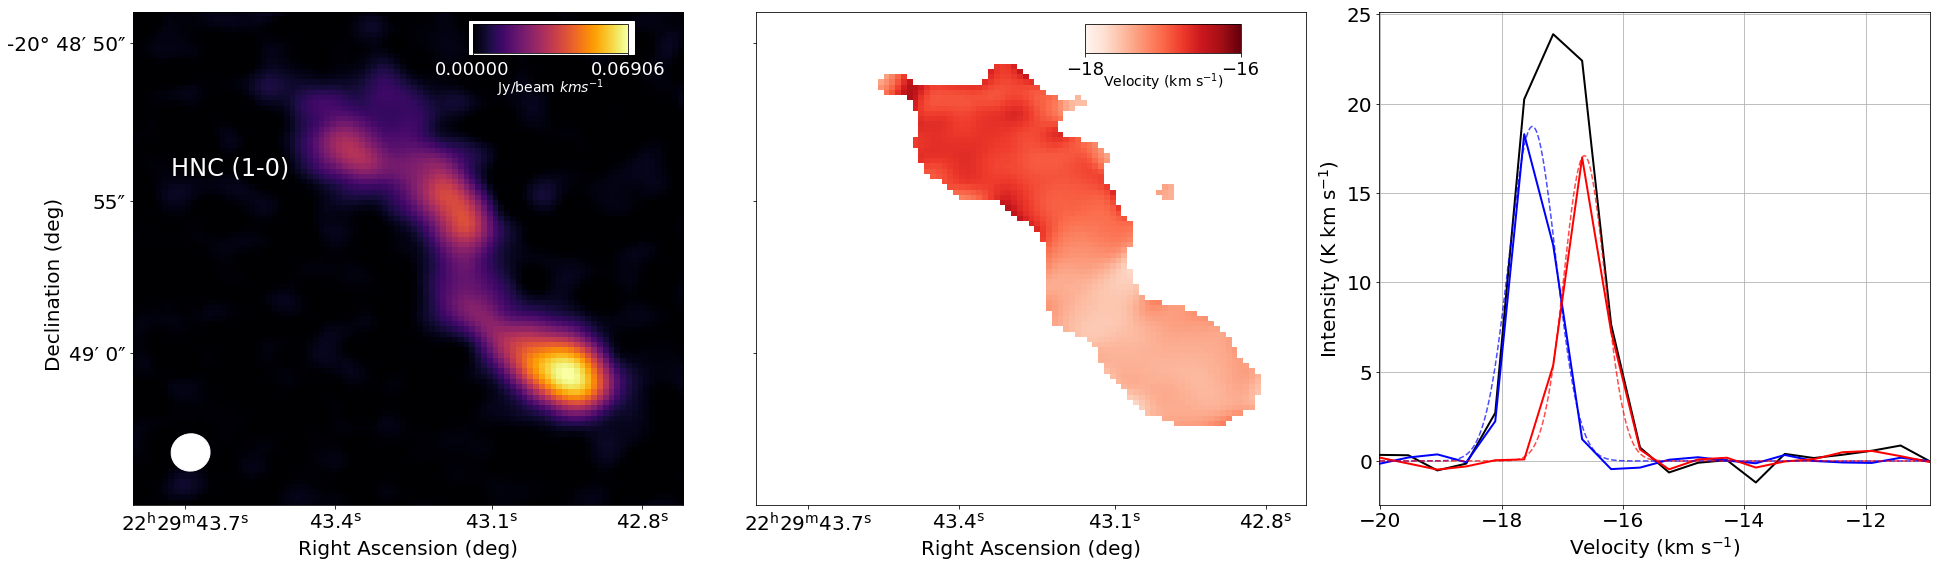

In [3]:
moment_maps_b(globule = 'GlobB', source = 'HNC')

In [208]:
def moment_maps_c(globule = 'GlobB', source = 'CCH_32'):
    path = globule + '_' + source + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header

    data1 = data[0,:,:,:]

    freq_start = header["CRVAL3"]
    freq_inc = header["CDELT3"]

    v_channels = np.arange(header["NAXIS3"])

    #define velocity as km/s blocks
    frequency = freq_start + (freq_inc * v_channels)
    frequency = np.array(frequency, dtype = float)

    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000

    vel_inc = 3e8*(-(header["CDELT3"]/header["RESTFRQ"]))/1000
    #print(vel_inc)

    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - header["CRPIX1"]+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - header["CRPIX2"]+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)

    if globule == 'GlobB':
        figure = plt.figure(figsize=[27, 8])
        x1 = round(header["CRPIX1"]-(ra_start-337.4325)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.428)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(20.818+dec_start)/dec_inc)-2
        y2 = round(header["CRPIX2"]-(20.81354+dec_start)/dec_inc)-2
    else:
        figure = plt.figure(figsize=[24, 8])
        x1 = round(header["CRPIX1"]-(ra_start-337.40975)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.40565)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+20.80087)/dec_inc)-1
        y2 = round(header["CRPIX2"]-(dec_start+20.796)/dec_inc)-1

    print(x1, x2, y1, y2)
    #print(x2-x1, y2-y1)

    data2 = data1[:, :, np.arange(x1, x2)]
    data3 = data2[:, np.arange(y1, y2), :]

    integrated = np.sum(data3[:, :, :], axis = 0)

    max_val = np.nanmax(integrated)
    #print(max_val)

    if source == '12CO':
        if globule == 'GlobB':
            d = 0.25
            array = [11, 12, 13, 14, 15, 16, 17]
        else:
            d = 0.07
    elif source == '13CO':
        if globule == 'GlobB':
            d = 0.25
            array = [11, 12, 13, 14, 15]
        else:
            d = 0.1
    elif source == 'C18O':
        if globule == 'GlobB':
            d = 0.28
            array = [11, 12, 13, 14]
        else:
            d = 0.15
    elif source == 'CCH':
        if globule == 'GlobB':
            d = 0.25
            array = [26, 27, 28, 29]
        else:
            d = 0.15
            array = [25, 26]
    elif source == 'CCH_32':
        if globule == 'GlobB':
            d = 0.15
            array = [6, 7, 8]
        else:
            d = 0.08
            array = [37, 38]
    elif source == 'HC3N':
        if globule == 'GlobB':
            d = 0.3
            array = [15, 16]
        else:
            d = 0.25
            array = [14, 15]
    elif source == 'HCN':
        if globule == 'GlobB':
            d = 0.06
            array = [26, 27, 28, 29, 30]
        else:
            d = 0.08
            array = [25, 26]
    elif source == 'HCN_32':
        if globule == 'GlobB':
            d = 0.065
            array = [11, 12, 13, 14, 15, 16, 17]
        else:
            d = 0.04
            array = [36, 37, 38, 39]
    elif source == 'HCOp':
        if globule == 'GlobB':
            d = 0.08
            array = [26, 27, 28, 29, 30]
        else:
            d = 0.1
            array = [25, 26]
    elif source == 'HCOp_32':
        if globule == 'GlobB':
            d = 0.1
            array = [13, 14, 15, 16, 17, 18]
        else:
            d = 0.08
            array = [37, 38, 39, 40]
    elif source == 'HNC':
        if globule == 'GlobB':
            d = 0.3
            array = [4, 5, 6, 7]
        else:
            d = 0.08
            array = [24, 25, 26, 27]
    elif source == 'HNC_32':
        if globule == 'GlobB':
            d = 0.2
            array = [14, 15, 16, 17, 18]
        else:
            d = 0.12
            array = [37, 38, 39]

    integrated = np.sum(data3[:, :, :], axis = 0)

    moment0 = np.sum(data3[array, :, :], axis = 0)

    max_value = np.nanmax(moment0)

    mom0 = np.ma.array(moment0)*abs(vel_inc)
    maximum = np.nanmax(mom0)

    freq_channels = np.arange(header["NAXIS3"])

    frequency = freq_start + (freq_inc * freq_channels)
    frequency = np.array(frequency, dtype = float)
    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000

    #Go from Moment 0 to Moment 1
    intermediate = np.sum(data1[array,:,:] * velocity[array,np.newaxis,np.newaxis], axis=0)
    intermediate_x = intermediate[:, np.arange(x1, x2)]
    intermediate_y = intermediate_x[np.arange(y1, y2), :]
    moment1 = intermediate_y/moment0

    #Adding in the mask
    sigma_mask = sigma_clip(moment0, sigma=3, maxiters=None, cenfunc='mean')
    newmask = (moment0 < np.amax(sigma_mask))
    #maskednoise = np.ma.masked_array(moment0, mask = newmask)

    mom1 = np.ma.array(moment1, mask=newmask)

    #sigma_mask = sigma_clip(moment0, sigma=2.5, maxiters=None, cenfunc='mean')
    #newmask = (moment0 < np.amax(sigma_mask))
    #mom0 = np.ma.array(moment0, mask = newmask)*abs(vel_inc)

    extent=[ra[x1],ra[x2],dec[y1],dec[y2]]

    ax1 = figure.add_subplot(1, 3, 1)
    bmaj = header['BMAJ']#major beam width
    bmin = header['BMIN'] #minor beam width
    bpa = header['BPA']
    beam = Ellipse(xy=(ra[x1 + 10], dec[y1 + 10]), width=bmaj, height=bmin, angle=bpa, color = 'white', zorder = 1)
    ax1.add_artist(beam)

    print(source, np.nansum(mom0))
    print(np.nanmax(mom0))

    dec_val4 = np.abs(dec + 20.7972222).argmin()
    dec_val3 = np.abs(dec + 20.7986111).argmin()
    dec_val2 = np.abs(dec + 20.8000000).argmin()
    #dec_val1 = np.abs(dec + 20.8180556).argmin()
    ax1.set_yticks([dec[dec_val2], dec[dec_val3], dec[dec_val4]])
    ax1.set_yticklabels(['48′ 0″','55″','-20° 47′ 50″'], fontsize = 14)

    ra_val1 = np.abs(ra - 337.4091667 ).argmin()
    ra_val2 = np.abs(ra - 337.4079167).argmin()
    ra_val3 = np.abs(ra - 337.4066667).argmin()
    #ra_val4 = np.abs(ra - 337.4287500).argmin()
    ax1.set_xticks([ra[ra_val1], ra[ra_val2], ra[ra_val3]])
    ax1.set_xticklabels(['$\mathrm{22^{h}29^{m}38.2^{s}}$', '$\mathrm{37.9^{s}}$', '$\mathrm{37.6^{s}}$'], fontsize = 14)
    
    ax2 = figure.add_subplot(1, 3, 2)
    ra_val1 = np.abs(ra - 337.4091667 ).argmin()
    ra_val2 = np.abs(ra - 337.4079167).argmin()
    ra_val3 = np.abs(ra - 337.4066667).argmin()
    #ra_val4 = np.abs(ra - 337.4287500).argmin()
    ax2.set_xticks([ra[ra_val1], ra[ra_val2], ra[ra_val3]])
    ax2.set_xticklabels(['$\mathrm{22^{h}29^{m}38.2^{s}}$', '$\mathrm{37.9^{s}}$', '$\mathrm{37.6^{s}}$'], fontsize = 14)
    
    dec_val4 = np.abs(dec + 20.8138889).argmin()
    dec_val3 = np.abs(dec + 20.8152778).argmin()
    dec_val2 = np.abs(dec + 20.8166667).argmin()
    #dec_val1 = np.abs(dec + 20.8180556).argmin()
    ax2.set_yticks([dec[dec_val2], dec[dec_val3], dec[dec_val4]])
    ax2.set_yticklabels([' ',' ',' '], fontsize = 14)

    plt.subplot(131)
    cm = plt.cm.get_cmap('inferno')
    plt.imshow(mom0, origin= 'lower', cmap=cm, zorder = 0, aspect = 'auto', extent = extent)

    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    #plt.set_facecolor("black")
    plt.xlabel('Right Ascension (deg)',fontsize=20)
    #plt.ylabel('DEC (deg)',fontsize=20)
    figure.text(0.04, 0.5, 'Declination (deg)', fontsize=20, horizontalalignment='center', verticalalignment='center', rotation = 'vertical')
    figure.text(0.285, 0.84, 'Jy/beam $km s^{-1}$', fontsize=14, horizontalalignment='center', verticalalignment='center', rotation = 'horizontal', color = 'white')
    figure.text(0.13, 0.8, 'HC$_3$N', fontsize=24, horizontalalignment='center', verticalalignment='center', rotation = 'horizontal', color = 'white')

    br = Rectangle(xy = (ra[round(x2*0.905)], dec[round(y2*0.972)]), width = 0.315*(ra[x2]-ra[x1]), height = 0.065*(dec[y2]-dec[y1]), color = 'white')
    ax1.add_artist(br)
    cbaxes1 = figure.add_axes([0.245, 0.9, 0.08, 0.05], zorder = 4) 
    cbar1 = plt.colorbar(cax=cbaxes1, ticks=[0., maximum], orientation='horizontal')
    cbar1.outline.set_edgecolor('white')
    cbar1.outline.set_linewidth(2)

    for t in cbar1.ax.get_xticklabels():
        t.set_fontsize(18)
        t.set_color('white')
    plt.clim(0.0, maximum)

    plt.subplot(132)
    if globule == 'GlobB':
        cm2 = plt.cm.get_cmap('Reds')
        plt.imshow(mom1, origin='lower', cmap=cm2, extent = extent, aspect = 'auto')
        plt.clim(-18, -16) #Globule B
    elif globule == 'GlobC':
        cm2 = plt.cm.get_cmap('Blues_r')
        plt.imshow(mom1, origin='lower', cmap=cm2, extent = extent, aspect = 'auto')
        plt.clim(-28.5, -27) #Globule C

    plt.xticks(fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.xlabel('Right Ascension (deg)',fontsize=20)
    figure.text(0.605, 0.84,'Velocity ($km s^{-1}$)', fontsize=14, horizontalalignment='center', verticalalignment='center', rotation = 'horizontal', color = 'black')
    
    cbaxes2 = figure.add_axes([0.565, 0.9, 0.08, 0.05], zorder = 4) 
    cbar2 = plt.colorbar(cax=cbaxes2, ticks=[-28.5, -27], orientation='horizontal')
    
    for s in cbar2.ax.get_xticklabels():
        s.set_fontsize(18)
        s.set_color('black')
        
    X = np.arange(-40, -10, 0.0001)
        
    def gaussian(x, amp, cen, sigma):
        return amp * np.exp(-(x-cen)**2 /(2*sigma**2))   
    
    rng=range(len(velocity))
    spectrum = []
    for i in rng:
        spectrum += [np.nansum(data3[i,:,:])]
        
    #popt1, pcov1 = curve_fit(gaussian, velocity, spectrum, p0 = [10, -35, 0.5])    
    #popt2, pcov2 = curve_fit(gaussian, velocity, spectrum, p0 = [39, -28, 0.25])    
    #popt3, pcov3 = curve_fit(gaussian, velocity, spectrum, p0 = [20, -23, 0.5]) 
    
    #print(popt1, popt2, popt3)
    
    plt.subplot(133)
    plt.plot(velocity, spectrum, lw = 2, color = 'black')
    if source == 'CCH':
        plt.plot(X, gaussian(X, 4.97015, -27.91920, 0.43252), color = 'black', ls = 'dashed', alpha = 0.7)
    elif source == 'CCH_32':
        plt.plot(X, gaussian(X, 48.58054, -30.86719, 0.26415), color = 'black', ls = 'dashed', alpha = 0.7)
        plt.plot(X, gaussian(X, 66.47686, -27.99710, 0.26232), color = 'black', ls = 'dashed', alpha = 0.7)
    elif source == 'HC3N':
        plt.plot(X, gaussian(X, 1.54236, -27.96822, 0.40432), color = 'black', ls = 'dashed', alpha = 0.7)
    elif source == 'HCN':
        plt.plot(X, gaussian(X, 12.21986, -34.92187, 0.26113), color = 'black', ls = 'dashed', alpha = 0.7)
        plt.plot(X, gaussian(X, 38.96105, -27.86704, 0.29056), color = 'black', ls = 'dashed', alpha = 0.7)
        plt.plot(X, gaussian(X, 20.71648, -23.02081, 0.28796), color = 'black', ls = 'dashed', alpha = 0.7)
    elif source == 'HCN_32':
        plt.plot(X, gaussian(X, 30.02010, -30.44689, 0.18367), color = 'black', ls = 'dashed', alpha = 0.7)
        plt.plot(X, gaussian(X, 141.17922, -28.14590, 0.38295), color = 'black', ls = 'dashed', alpha = 0.7)
        plt.plot(X, gaussian(X, 38.69774, -26.47922, 0.20809), color = 'black', ls = 'dashed', alpha = 0.7)
    elif source == 'HCOp':
        plt.plot(X, gaussian(X, 35.19290, -27.90455, 0.30502), color = 'black', ls = 'dashed', alpha = 0.7)
    elif source == 'HCOp_32':
        plt.plot(X, gaussian(X, 242.76563, -27.89820, 0.28405), color = 'black', ls = 'dashed', alpha = 0.7)
    elif source == 'HNC':
        plt.plot(X, gaussian(X, 29.47175, -27.86487, 0.37175), color = 'black', ls = 'dashed', alpha = 0.7)
    elif source == 'HNC_32':
        plt.plot(X, gaussian(X, 75.38004, -27.86341, 0.45169), color = 'black', ls = 'dashed', alpha = 0.7)
    
    plt.xlabel('Velocity km s$^{-1}$', fontsize = 20)
    plt.ylabel('Intensity (K km s$^{-1}$)', fontsize = 20)
    plt.xlim(-40, -20)
    plt.xticks(ticks = np.arange(-40, -15, 5), fontsize = 20)
    plt.yticks(fontsize = 20)
    plt.grid()
        
    plt.tight_layout()
    plt.savefig(globule + '_' + source + '_' + 'Moment_Maps_Final.png', bbox_inches='tight')

256 343 270 373
HC3N 2.2642567
0.012883816


Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


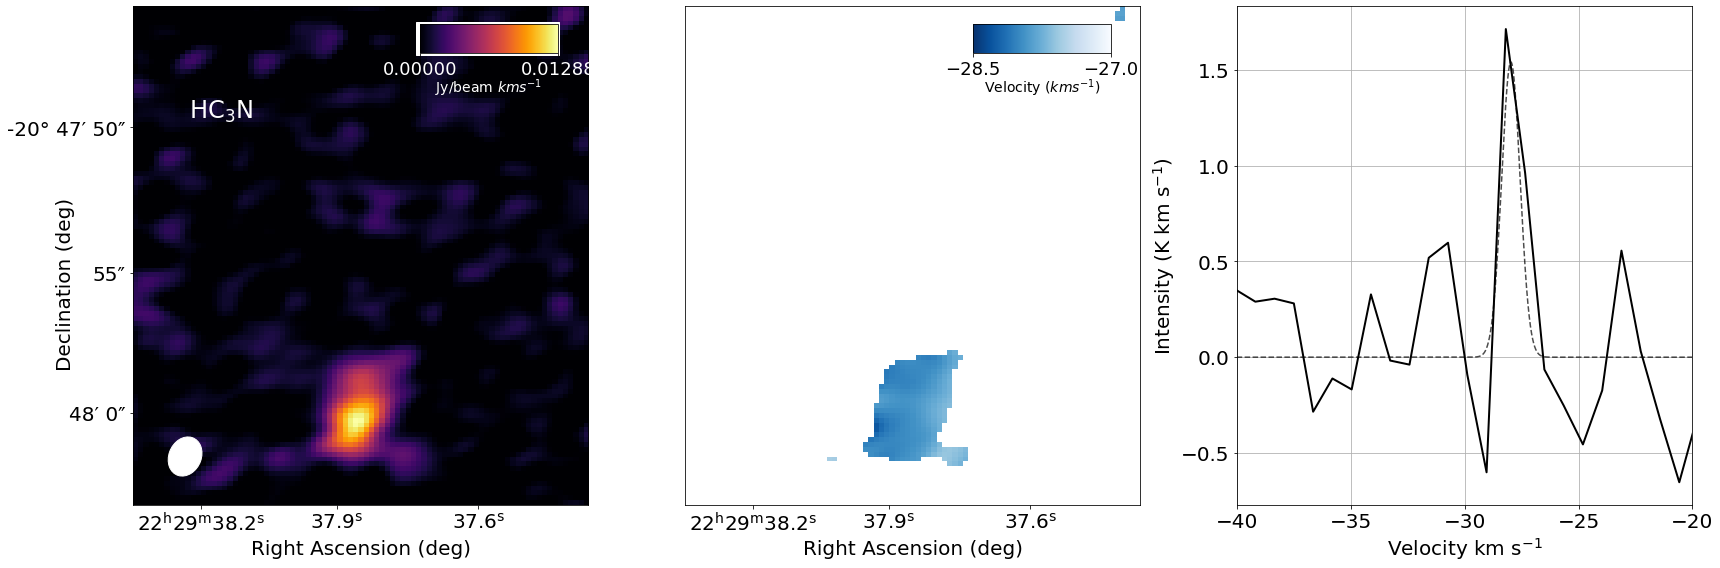

In [209]:
moment_maps_c(globule = 'GlobC', source = 'HC3N')